### Import Libraries and Read Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.rcParams['figure.figsize'] = [15, 5]
from IPython import display
from ipywidgets import interact, widgets

## Read Data for Cases, Deaths and Recoveries
Recoveries_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
Deaths_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
ConfirmedCases_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


In [0]:
### Melt the dateframe into the right shape and set index
def cleandata(df_raw):
    df_cleaned=df_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Cases',var_name='Date')
    df_cleaned=df_cleaned.set_index(['Country/Region','Province/State','Date'])
    return df_cleaned 

### Get Countrywise Data
def countrydata(df_cleaned, oldname, newname):
    df_country=df_cleaned.groupby(['Country/Region','Date'])['Cases'].sum().reset_index()
    df_country=df_country.set_index(['Country/Region','Date'])
    df_country.index=df_country.index.set_levels([df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country=df_country.sort_values(['Country/Region','Date'],ascending=True)
    df_country=df_country.rename(columns={oldname:newname})
    return df_country

### Get DailyData from Cumulative sum
def dailydata(dfcountry,oldname,newname):
    dfcountrydaily=dfcountry.groupby(level=0).diff().fillna(0)
    dfcountrydaily=dfcountrydaily.rename(columns={oldname:newname})
    return dfcountrydaily

In [0]:
# Clean all datasets
ConfirmedCases=cleandata(ConfirmedCases_raw)
Deaths=cleandata(Deaths_raw)
Recoveries=cleandata(Recoveries_raw)
# confirmed_total_date = ConfirmedCases.groupby(['Date']).agg({'ConfirmedCases':['sum']})


In [0]:
# Get countrywise data
ConfirmedCasesCountry=countrydata(ConfirmedCases,'Cases','Total Confirmed Cases')
DeathsCountry=countrydata(Deaths,'Cases','Total Deaths')
RecoveriesCountry=countrydata(Recoveries,'Cases','Total Recoveries')


In [0]:
# Get Daily Data
NewCasesCountry=dailydata(ConfirmedCasesCountry,'Total Confirmed Cases','Daily New Cases')
NewDeathsCountry=dailydata(DeathsCountry,'Total Deaths','Daily New Deaths')
NewRecoveriesCountry=dailydata(RecoveriesCountry,'Total Recoveries','Daily New Recoveries')

In [0]:
CountryConsolidated=pd.merge(ConfirmedCasesCountry,NewCasesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,NewDeathsCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,DeathsCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,RecoveriesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,NewRecoveriesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated['Active Cases']=CountryConsolidated['Total Confirmed Cases']-CountryConsolidated['Total Deaths']-CountryConsolidated['Total Recoveries']
CountryConsolidated['Share of Recoveries - Closed Cases']=np.round(CountryConsolidated['Total Recoveries']/(CountryConsolidated['Total Recoveries']+CountryConsolidated['Total Deaths']),2)
CountryConsolidated['Death to Cases Ratio']=np.round(CountryConsolidated['Total Deaths']/CountryConsolidated['Total Confirmed Cases'],3)


In [7]:
GlobalTotals=CountryConsolidated.reset_index().groupby('Date').sum()
GlobalTotals['Share of Recoveries - Closed Cases']=np.round(GlobalTotals['Total Recoveries']/(GlobalTotals['Total Recoveries']+GlobalTotals['Total Deaths']),2)
GlobalTotals['Death to Cases Ratio']=np.round(GlobalTotals['Total Deaths']/GlobalTotals['Total Confirmed Cases'],3)
GlobalTotals.tail(7).T

Date,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10
Total Confirmed Cases,3583055.00,3662691.00,3756069.00,3845718.00,3938064.00,4024009.000,4101699.000
Daily New Cases,76326.00,79636.00,93378.00,89649.00,92346.00,85945.000,77690.000
Daily New Deaths,4067.00,5702.00,6616.00,5712.00,5331.00,4413.000,3398.000
Total Deaths,251537.00,257239.00,263855.00,269567.00,274898.00,279311.000,282709.000
Total Recoveries,1162724.00,1198832.00,1245413.00,1284741.00,1322050.00,1375624.000,1408980.000
Daily New Recoveries,37488.00,36108.00,46581.00,39328.00,37309.00,53574.000,33356.000
Active Cases,2168794.00,2206620.00,2246801.00,2291410.00,2341116.00,2369074.000,2410010.000
Share of Recoveries - Closed Cases,0.82,0.82,0.83,0.83,0.83,0.830,0.830
Death to Cases Ratio,0.07,0.07,0.07,0.07,0.07,0.069,0.069


###  Cases Worldwide by Status: Total Confirmed, Active, Deaths, Recoveries

In [8]:
GlobalTotals.iloc[-1]

Total Confirmed Cases                 4101699.000
Daily New Cases                         77690.000
Daily New Deaths                         3398.000
Total Deaths                           282709.000
Total Recoveries                      1408980.000
Daily New Recoveries                    33356.000
Active Cases                          2410010.000
Share of Recoveries - Closed Cases          0.830
Death to Cases Ratio                        0.069
Name: 2020-05-10 00:00:00, dtype: float64

In [0]:
plt.style.use('seaborn-dark')

In [10]:
chartcol='red'
fig = make_subplots(rows=3, cols=2,shared_xaxes=True,
                    specs=[[{}, {}],[{},{}],
                       [{"colspan": 2}, None]],
                    subplot_titles=('Total Confirmed Cases','Active Cases','Deaths','Recoveries','Death to Cases Ratio'))
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Confirmed Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=1)
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Active Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=2)
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Total Deaths'],
                         mode='lines+markers',
                         name='Deaths',
                         line=dict(color="green",width=2)),
                         row=2,col=1)
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Total Recoveries'],
                         mode='lines+markers',
                         name='Recoveries',
                         line=dict(color=chartcol,width=2)),
                         row=2,col=2)
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Death to Cases Ratio'],
                         mode='lines+markers',
                         line=dict(color=chartcol,width=2)),
                         row=3,col=1)
fig.update_layout(showlegend=False)

### Cases by Region (Insite or Outside China)

In [11]:
# Cases by Region (inside or Outside China)
TotalCasesLoc=CountryConsolidated.reset_index()
TotalCasesLoc.head()
TotalCasesLoc['Location']=np.where(TotalCasesLoc['Country/Region']=='Mainland China','Mainland China','Outside China')
TotalCasesLocaggregated=TotalCasesLoc.groupby(['Location','Date'])['Active Cases'].sum().reset_index()
ActiveCasesChina=TotalCasesLocaggregated[TotalCasesLocaggregated.loc[:,'Location']=='Mainland China']
ActiveCasesExcludingChina=TotalCasesLocaggregated[TotalCasesLocaggregated.loc[:,'Location']=='Outside China']
ActiveCasesExcludingChina.tail(4).T

,106,107,108,109
Location,Outside China,Outside China,Outside China,Outside China
Date,2020-05-07 00:00:00,2020-05-08 00:00:00,2020-05-09 00:00:00,2020-05-10 00:00:00
Active Cases,2291410,2341116,2369074,2410010


In [12]:
fig = make_subplots(rows=1, cols=2,shared_xaxes=True,
                   subplot_titles=('Active Cases Excluding Mainland China', 'Active Cases in Mainland China'))
fig.add_trace(go.Scatter(x=ActiveCasesExcludingChina['Date'],y=ActiveCasesExcludingChina['Active Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=1)
fig.add_trace(go.Scatter(x=ActiveCasesChina['Date'],y=ActiveCasesChina['Active Cases'],
                         mode='lines+markers',
                         name='New Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=2)

fig.update_layout(showlegend=True)

### Cases by Country

In [13]:
def plotcountry(Country):
    fig = make_subplots(rows=3, cols=2,shared_xaxes=True,
                    specs=[[{}, {}],[{},{}],
                       [{"colspan": 2}, None]],
                    subplot_titles=('Total Confirmed Cases','Active Cases','Deaths','Recoveries','Death to Cases Ratio'))
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Confirmed Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=1)
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Active Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=2)
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Total Deaths'],
                         mode='lines+markers',
                         name='Total Deaths',
                         line=dict(color="green",width=2)),
                         row=2,col=1)
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Total Recoveries'],
                         mode='lines+markers',
                         name='Total Recoveries',
                         line=dict(color=chartcol,width=2)),
                         row=2,col=2)
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Death to Cases Ratio'],
                         mode='lines+markers',
                         name='Death to Cases Ratio',
                         line=dict(color=chartcol,width=2)),
                         row=3,col=1)
    fig.update_layout(showlegend=True)
    
    return fig
CountriesList=['US','Italy','Germany', 'United Kingdom', 'Ireland','Pakistan','Iran','South Korea','Japan','Netherlands']
interact(plotcountry, Country=widgets.Dropdown(options=CountriesList))

interactive(children=(Dropdown(description='Country', options=('US', 'Italy', 'Germany', 'United Kingdom', 'Ir…

<function __main__.plotcountry>

### Cumulative Data by Country

In [0]:
max_index=CountryConsolidated.reset_index()['Date'].max()
CumulativeCountryData=CountryConsolidated.reset_index().set_index('Date').loc[max_index].set_index('Country/Region')
top10countriesbycases=CumulativeCountryData['Total Confirmed Cases'].sort_values(ascending=False).head(10).index.tolist()
top10countriesbycasesexclChina=CumulativeCountryData[~CumulativeCountryData.index.isin(['Mainland China','Others'])]['Total Confirmed Cases'].sort_values(ascending=False).head(10).index.tolist()
top10countriescumulative=CumulativeCountryData.loc[top10countriesbycases]
top10countriescumulativexclChina=CumulativeCountryData.loc[top10countriesbycasesexclChina]

In [15]:
top10countriescumulative

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Country/Region,,,,,,,,,
US,1329260,19710.0,731.0,79526,216169,3635.0,1033565,0.73,0.060
Spain,224350,772.0,143.0,26621,136166,2214.0,61563,0.84,0.119
United Kingdom,220449,3924.0,268.0,31930,1002,1.0,187517,0.03,0.145
Italy,219070,802.0,165.0,30560,105186,2155.0,83324,0.77,0.139
Russia,209688,11012.0,88.0,1915,34306,2390.0,173467,0.95,0.009
France,177094,312.0,70.0,26383,56327,179.0,94384,0.68,0.149
Germany,171879,555.0,20.0,7569,144400,1100.0,19910,0.95,0.044
Brazil,162699,6638.0,467.0,11123,64957,3272.0,86619,0.85,0.068
Turkey,138657,1542.0,47.0,3786,92691,3211.0,42180,0.96,0.027


In [16]:
fig = go.Figure(go.Bar(x=top10countriescumulativexclChina.index, y=top10countriescumulativexclChina['Total Confirmed Cases'],
                      text=top10countriescumulativexclChina['Death to Cases Ratio'],
            textposition='outside'))
fig.update_layout(title_text='Top countries by Cases and their Death Rates',yaxis_title='Total Cases')

### Total Cases by number of days since 'Outbreak'

In [0]:
ItalyFirstCase=CountryConsolidated.loc['Italy']['Total Confirmed Cases'].reset_index().set_index('Date')
USFirstCase=CountryConsolidated.loc['US']['Total Confirmed Cases'].reset_index().set_index('Date')
IranFirstCase=CountryConsolidated.loc['Iran']['Total Confirmed Cases'].reset_index().set_index('Date')
GermanyFirstCase=CountryConsolidated.loc['Germany']['Total Confirmed Cases'].reset_index().set_index('Date')
SingaporeFirstCase=CountryConsolidated.loc['Singapore']['Total Confirmed Cases'].reset_index().set_index('Date')

ItalyGrowth=ItalyFirstCase[ItalyFirstCase.ne(0)].dropna().reset_index()
USGrowth=USFirstCase[USFirstCase.ne(0)].dropna().reset_index()
IranGrowth=IranFirstCase[IranFirstCase.ne(0)].dropna().reset_index()
GermanyGrowth=GermanyFirstCase[GermanyFirstCase.ne(0)].dropna().reset_index()
SingaporeGrowth=SingaporeFirstCase[SingaporeFirstCase.ne(0)].dropna().reset_index()


In [18]:
def first_case_growth(country):
    """Get the first case from the country"""
    first = CountryConsolidated.loc[country]['Total Confirmed Cases'].reset_index().set_index('Date')
    growth = first[first.ne(0)].dropna().reset_index()
    return first, growth

IrelandFirstCase, IrelandGrowth = first_case_growth('Ireland')
UKFirstCase, UKGrowth = first_case_growth('United Kingdom')
USfc, USg = first_case_growth('US')
growth = [x for x in USg['Total Confirmed Cases']]
z = zip(growth, growth[1:])
percent = [(a / float(b)) for a,b in list(z)[-6:]]
sum(percent) / len(percent)

def growth_meter(numba, growth, days=10):
    grow = numba * (1 + growth)
    yield grow
    days -= 1;
    if days == 0:
        return
CountryConsolidated.loc['US'].columns
percent

[0.9800921824285445,
 0.9796800048156273,
 0.9779701723834806,
 0.9790440125583268,
 0.9804352640219923,
 0.9851722010742819]

In [19]:

fig = make_subplots(rows=2, cols=2,shared_xaxes=True,
                   subplot_titles=('Italy','Ireland','US','UK'))

fig.update_xaxes(title_text="Number of Days since Outbreak", row=2, col=1)

fig.update_xaxes(title_text="Number of Days since Outbreak", row=2, col=2)

fig.add_trace(go.Scatter(x=ItalyGrowth.index,y=ItalyGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=1,col=1)
fig.add_trace(go.Scatter(x=IrelandGrowth.index,y=IrelandGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=1,col=2)
fig.add_trace(go.Scatter(x=USGrowth.index,y=USGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=2,col=1)
                          
fig.add_trace(go.Scatter(x=UKGrowth.index,y=UKGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=2,col=2)  

fig.update_layout(showlegend=False,title = 'Active Cases')

In [0]:
import requests
import re
from datetime import date

dates = []
r = requests.get('https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports')
csv_re = re.compile(r'(\d\d)-(\d\d)-(\d\d\d\d).csv')
for m, d, y in set(csv_re.findall(r.text)):
    dates.append(date(year=int(y), month=int(m), day=int(d)))
newest = sorted(dates).pop()
csv_file = f'{newest.month:02}-{newest.day:02}-{newest.year:04}.csv'
all_raw=pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{csv_file}')

In [21]:
ConfirmedCases_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Lat,266.0,21.259359,24.747943,-51.7963,6.907750,23.488100,41.143200,7.170690e+01
Long,266.0,22.432499,70.478908,-135.0000,-18.093125,20.921188,77.191525,1.780650e+02
1/22/20,266.0,2.086466,27.279200,0.0000,0.000000,0.000000,0.000000,4.440000e+02
1/23/20,266.0,2.458647,27.377862,0.0000,0.000000,0.000000,0.000000,4.440000e+02
1/24/20,266.0,3.537594,34.083035,0.0000,0.000000,0.000000,0.000000,5.490000e+02
...,...,...,...,...,...,...,...,...
5/6/20,266.0,14120.560150,81256.457615,0.0000,95.250000,556.000000,2872.750000,1.229331e+06
5/7/20,266.0,14457.586466,83068.942550,0.0000,96.500000,562.500000,2939.500000,1.257023e+06
5/8/20,266.0,14804.751880,84847.767125,0.0000,101.250000,586.000000,3021.750000,1.283929e+06
5/9/20,266.0,15127.853383,86525.424820,0.0000,107.750000,619.000000,3040.750000,1.309550e+06


In [0]:
cc_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
cc_raw.describe(include=[np.object]).T
cc_raw['Province/State'] = cc_raw['Province/State'].astype('category')
cc_raw['Country/Region'] = cc_raw['Country/Region'].astype('category')
cc = cc_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Cases',var_name='Date').set_index(['Country/Region','Province/State','Date'])

In [0]:
ConfirmedCases_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


In [0]:
#nba.loc[nba["fran_id"] == "Lakers", "team_id"].value_counts()
cc = ConfirmedCases_raw

In [0]:
states=pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')

In [0]:
#nba.loc[nba["fran_id"] == "Lakers", "team_id"].value_counts()
states=pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
### Get Countrywise Data
def countrydata(df_cleaned, oldname, newname):
    df_country=df_cleaned.groupby(['Country/Region','Date'])['Cases'].sum().reset_index()
    df_country=df_country.set_index(['Country/Region','Date'])
    df_country.index=df_country.index.set_levels([df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country=df_country.sort_values(['Country/Region','Date'],ascending=True)
    df_country=df_country.rename(columns={oldname:newname})
    return df_country


In [27]:
states[states['state'] == "Massachusetts"].tail()

,date,state,fips,cases,deaths
3501,2020-05-05,Massachusetts,25,70271,4212
3556,2020-05-06,Massachusetts,25,72025,4420
3611,2020-05-07,Massachusetts,25,73721,4552
3666,2020-05-08,Massachusetts,25,75333,4702
3721,2020-05-09,Massachusetts,25,76743,4840


In [28]:
states[states['state'] == "Rhode Island"].tail()


,date,state,fips,cases,deaths
3521,2020-05-05,Rhode Island,44,9933,355
3576,2020-05-06,Rhode Island,44,10205,370
3631,2020-05-07,Rhode Island,44,10530,388
3686,2020-05-08,Rhode Island,44,10779,399
3741,2020-05-09,Rhode Island,44,10989,418


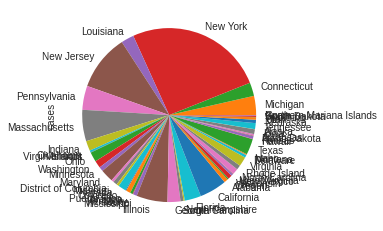

In [29]:
state_total = states.groupby('state').max()
state_total['percent death'] = state_total['deaths'] / state_total['cases']
state_total.sort_values(by='percent death', inplace=True, ascending=False)
state_total = state_total.drop(columns=['fips'])
state_total['cases'].plot(kind='pie')

In [30]:
def dod_state(name):
    '''Give the day over day results'''
    df = states[states['state'] == name]
    increase = [y - x for x,y in zip(df['cases'], df['cases'][1:])]
    days = df['date'][1:]
    df = pd.DataFrame(data=dict(increase=increase, date=days))
    fig = px.line(df, x=df['date'], y=df['increase'], title='{0} Increase Day Over Day'.format(name))
    return fig.show()

for names in sorted(['Rhode Island','Colorado', 'Massachusetts', 'Florida', 'Maryland', 'Georgia']):
    dod_state(names)

In [31]:
def state(name):
    state_cases = states[states['state'] == name]
    fig = px.line(state_cases, x="date", y='cases', title='{0} State Cases'.format(name))
    return fig.show()



for names in sorted(['Rhode Island','Colorado', 'Massachusetts', 'Florida', 'Maryland', 'Georgia']):
    state(names)

fig = go.Figure()
state_total.date

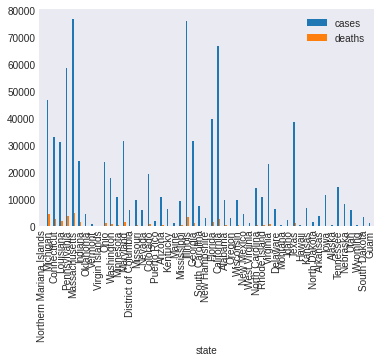

In [32]:
state_total[['cases', 'deaths']].drop('New York').drop('New Jersey').plot(kind='bar')
